In [1]:
# Import libraries
import sys
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow.contrib import learn
from tqdm import trange
from time import time
from Autoencoder.utils import *

In [2]:
class AutoEncoder(object):

  def __init__(self,
               sess,
               inputs,
               targets=None,
               b1=0.5,
               lr=1.,
               code_size=16,
               batch_size=256,
               n_epoch=200,
               cost_function='bce',
               name='autoencoder',
               optimizer='adadelta'):
    self.sess = sess  #tensorflow session
    self.b1 = b1  #beta1 for AdadeltaOptimizer
    self.lr = lr  #learning rate
    self.n_epoch = n_epoch  #number of epoch
    self.batch_size = batch_size
    self.inputs = inputs
    self.code_size = code_size  #embedding size
    self.load_dataset()
    if targets is not None:
      self.targets = targets  #for autoencoder, targets is the same to input
      self.gen_noisy_data()
    else:
      self.targets = inputs
    self.cost_function = cost_function
    self.optimizer = optimizer
    self.log = {'train_loss': [], 'valid_loss': []}

    self.name = name

    self.build_model()

  def build_model(self):
    code_size = self.code_size
    with tf.variable_scope(self.name) as scope:
      self.enc1 = tf.layers.dense(
          inputs=self.inputs,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='enc')
      self.enc2 = tf.layers.dense(
          inputs=self.enc1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='enc2')
      self.enc3 = tf.layers.dense(
          inputs=self.enc2,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='enc3')
      self.code = tf.layers.dense(
          inputs=self.enc3, units=code_size, activation=tf.nn.relu, name='code')

      self.dec1 = tf.layers.dense(
          inputs=self.code,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='dec')
      self.dec2 = tf.layers.dense(
          inputs=self.dec1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='dec2')
      self.dec3 = tf.layers.dense(
          inputs=self.dec2,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='dec3')
      self.recon_logits = tf.layers.dense(
          inputs=self.dec3, units=28 * 28, name='recon_logits')
      self.jacobian_op = self.jacobian(self.code, self.inputs)
      if self.cost_function == 'mse':
        self.recon = self.recon_logits
        self.cost = tf.reduce_mean(tf.pow(self.targets - self.recon_logits, 2))
      elif self.cost_function == 'bce':
        self.recon = tf.nn.sigmoid(self.recon_logits)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.targets, logits=self.recon_logits))

      else:
        raise NotImplementedError

  def train(self):
    if self.optimizer == 'adadelta':
      self.optim = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
    elif self.optimizer == 'adam':
      self.optim = tf.train.AdamOptimizer(
          self.lr, beta1=self.b1).minimize(self.cost)
    elif self.optimizer == 'rmsprop':
      self.optim = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
    else:
      raise NotImplementedError
    init = tf.global_variables_initializer()
    self.sess.run(init)

    X = self.inputs
    t0 = time()
    if self.targets is not self.inputs:
      print('Denoising autoencoder')
      Y = self.targets
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX, self.trX_noisy)
        for batch, noisy_batch in iter_data(
            self.trX, self.trX_noisy, size=self.batch_size):
          self.optim.run(
              session=self.sess, feed_dict={X: noisy_batch,
                                            Y: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]
        valid_noisy_batch = self.vaX_noisy[idxs]

        self.log['train_loss'].append(
            self.cost.eval(
                session=self.sess, feed_dict={X: noisy_batch,
                                              Y: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(
                session=self.sess,
                feed_dict={X: valid_noisy_batch,
                           Y: valid_batch}))
      print("final loss %g, total cost time: %.2fs" % (self.cost.eval(
          session=self.sess, feed_dict={X: self.teX_noisy,
                                        Y: self.teX}), time() - t0))

    else:
      print('Audoencoder')
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX)
        for batch in iter_data(self.trX, size=self.batch_size):
          self.optim.run(session=self.sess, feed_dict={X: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]

        self.log['train_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: valid_batch}))
      print("final loss %g, total cost time: %.2fs" %
            (self.cost.eval(session=self.sess, feed_dict={X: self.teX}),
             time() - t0))

  def load_dataset(self):
    mnist = learn.datasets.load_dataset("mnist")
    self.trX = mnist.train.images  # Returns np.array
    self.vaX = mnist.validation.images  # Returns np.array
    self.teX = mnist.test.images

  def gen_noisy_data(self):
    # Noise scale
    noise_factor = 0.4
    trX_noisy = self.trX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.trX.shape)
    vaX_noisy = self.vaX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.vaX.shape)
    teX_noisy = self.teX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.teX.shape)

    # Range of our dataset is [0,1]
    self.trX_noisy = np.clip(trX_noisy, 0., 1.)
    self.vaX_noisy = np.clip(vaX_noisy, 0., 1.)
    self.teX_noisy = np.clip(teX_noisy, 0., 1.)

  def encode(self, inputs):

    return self.code.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def reconstruct(self, inputs):
    return self.recon.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def jacobian(self, y, x):
    # For function f: mapping from single column x to multiple values ys
    # Note: tf.gradients returns sum(dy/dx)
    # for each x in xs, so we need to compute each y seperatedly.
    jacobian_flat = tf.concat(
        [tf.gradients(y_i, x)[0] for y_i in tf.unstack(y, axis=1)], axis=0)
    return jacobian_flat

  def get_jaco_matrix(self, xbatch):
    jaco_matrix = []
    for x in xbatch:
      jaco_matrix.append(
          self.jacobian_op.eval(
              session=self.sess, feed_dict={self.inputs: x.reshape(1, -1)})
          .reshape(1, self.code_size, 28 * 28))
    return np.concatenate(jaco_matrix)

In [10]:
# mnist = learn.datasets.load_dataset("mnist")
# trX = mnist.train.images  # Returns np.array
# vaX = mnist.validation.images  # Returns np.array
# teX = mnist.test.images
# print(trX.shape,vaX.shape,teX.shape)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
(55000, 784) (5000, 784) (10000, 784)


In [3]:
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 28 * 28])
autoencoder = AutoEncoder(sess=sess, inputs=X, optimizer='adadelta', lr=1)
autoencoder.train()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Audoencoder


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [10:10<00:00,  2.91s/it]


final loss 0.103025, total cost time: 611.03s


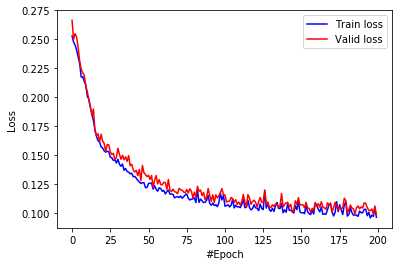

In [4]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

(10, 784)
(10, 28, 28)


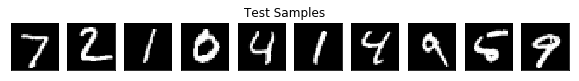

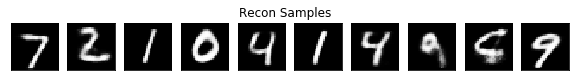

In [4]:
n = 10
print(autoencoder.teX[:n].shape)
orig_imgs = autoencoder.teX[:n].reshape(-1, 28, 28)
print(orig_imgs.shape)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, 28 * 28)).reshape(-1, 28, 28)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

(1, 16, 784)
(16,)


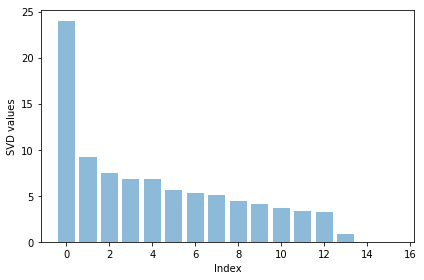

(16, 784)


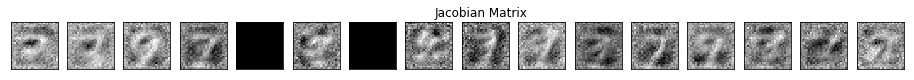

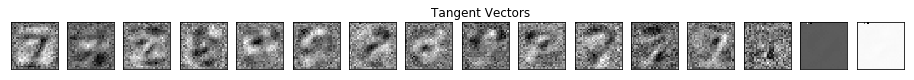

In [6]:
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
print(jaco_matrix.shape)
V = tangent_vecs(jaco_matrix[0])
print(V.shape)
plot_imgs(jaco_matrix.reshape(-1, 28, 28), n=16, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, 28, 28), n=16, title='Tangent Vectors')

In [7]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 28 * 28])
Y = tf.placeholder(tf.float32, shape=[None, 28 * 28])

# In our AutoEncoder class,
# it will automatically change to denoising autoencoder if "targets" is given.
autoencoder = AutoEncoder(
    sess=sess, inputs=X, targets=Y, optimizer='adadelta', lr=1)
# autoencoderModel = AutoEncoder(
#     sess=sess, inputs=X, optimizer='adam', niter=200, cost_function='mse')
autoencoder.train()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Denoising autoencoder


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:18<00:00,  1.62s/it]


final loss 0.115965, total cost time: 318.41s


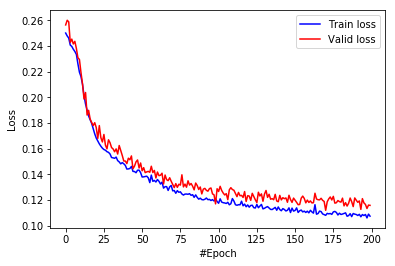

In [9]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

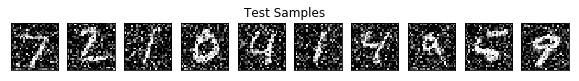

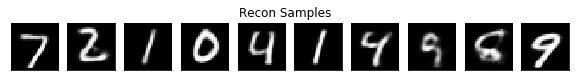

In [10]:
n = 10

orig_imgs = autoencoder.teX_noisy[:n].reshape(-1, 28, 28)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, 28 * 28)).reshape(-1, 28, 28)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

(16,)


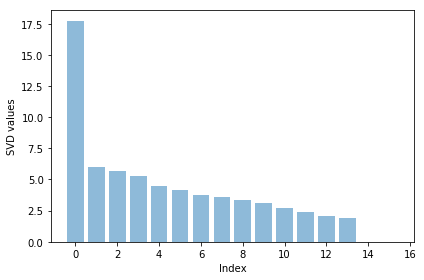

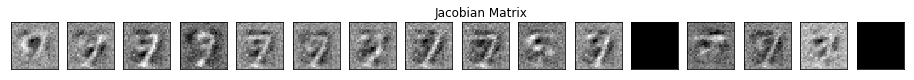

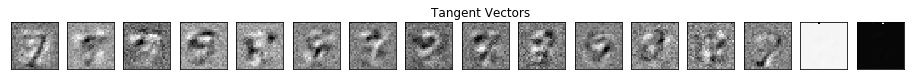

In [11]:
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
V = tangent_vecs(jaco_matrix[0])
plot_imgs(jaco_matrix.reshape(-1, 28, 28), n=16, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, 28, 28), n=16, title='Tangent Vectors')

#reset the system path
sys.path.pop()

#reset tensorflow graph
tf.reset_default_graph()
sess.close()

In [5]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

In [6]:
class DCGAN(object):

  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=128,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=2e-4,
               beta1=0.5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    self.learning_rate = learning_rate
    self.beta1 = beta1

    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):
    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(
        bce(self.D_logits_real, tf.ones_like(self.D)))
    self.d_loss_fake = tf.reduce_mean(
        bce(self.D_logits_fake, tf.zeros_like(self.D_)))
    self.g_loss = tf.reduce_mean(bce(self.D_logits_fake, tf.ones_like(self.D_)))

    self.d_loss = self.d_loss_real + self.d_loss_fake

    t_vars = tf.trainable_variables()
    # get variables for generator and discriminator,
    # since they are trained separately.
    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]

    self.saver = tf.train.Saver()

  def train(self):
    #get the optimization ops
    d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.d_loss, var_list=self.d_vars)
    g_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.g_loss, var_list=self.g_vars)
    init = tf.global_variables_initializer()
    self.sess.run(init)

    #generate random noise
    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    start_time = time.time()
    print('start training')
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % 2 == 0:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      # calculate the loss to monitor the training process
      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      # save the generated samples
      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image

      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(bn(conv2d(h0, self.df_dim, name='d_h1_conv')))
      h1 = flatten(h1)
      h2 = lrelu(bn(linear(h1, self.dfc_dim, 'd_h2_lin')))
      h3 = linear(h2, 1, 'd_h3_lin')

      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4)
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4)

      h0 = tf.nn.relu(bn(linear(z, self.gfc_dim, 'g_h0_lin')))

      h1 = tf.nn.relu(bn(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin')))
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(bn(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2')))
      return tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

In [13]:
# Specifiy model checkpoint directory & samples directory
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

tf.reset_default_graph()

sess = tf.Session()
dcgan = DCGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


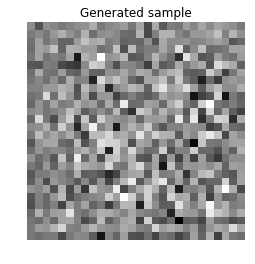

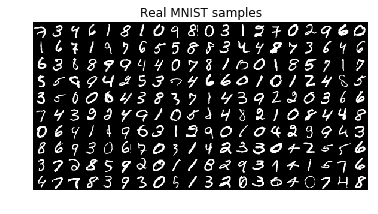

In [14]:
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = dcgan.G.eval(session=dcgan.sess, feed_dict={dcgan.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = dcgan.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

start training
Epoch: [ 0] time: 124.15s, d_loss: 1.0653, g_loss: 1.0458
Epoch: [ 1] time: 247.77s, d_loss: 1.1737, g_loss: 0.8963
Epoch: [ 2] time: 369.76s, d_loss: 1.2431, g_loss: 0.9107
Epoch: [ 3] time: 491.36s, d_loss: 1.2077, g_loss: 0.8747
Epoch: [ 4] time: 613.58s, d_loss: 1.1961, g_loss: 0.8589
Epoch: [ 5] time: 735.30s, d_loss: 1.1671, g_loss: 0.8529
Epoch: [ 6] time: 857.70s, d_loss: 1.2067, g_loss: 0.8339
Epoch: [ 7] time: 979.38s, d_loss: 1.1891, g_loss: 0.8413
Epoch: [ 8] time: 1100.92s, d_loss: 1.2214, g_loss: 0.8070
Epoch: [ 9] time: 1222.97s, d_loss: 1.2003, g_loss: 0.8288


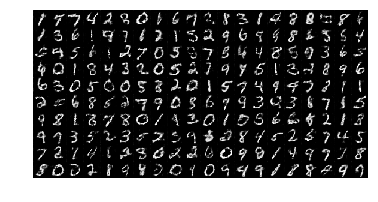

Epoch: [10] time: 1346.88s, d_loss: 1.2223, g_loss: 0.7955
Epoch: [11] time: 1468.64s, d_loss: 1.2817, g_loss: 0.8313
Epoch: [12] time: 1589.95s, d_loss: 1.2816, g_loss: 0.7871
Epoch: [13] time: 1711.40s, d_loss: 1.2188, g_loss: 0.8070
Epoch: [14] time: 1833.12s, d_loss: 1.2401, g_loss: 0.8346
Epoch: [15] time: 1954.61s, d_loss: 1.2230, g_loss: 0.8219
Epoch: [16] time: 2076.03s, d_loss: 1.2160, g_loss: 0.8145
Epoch: [17] time: 2197.15s, d_loss: 1.2124, g_loss: 0.8201
Epoch: [18] time: 2319.24s, d_loss: 1.2590, g_loss: 0.8460
Epoch: [19] time: 2440.57s, d_loss: 1.2419, g_loss: 0.8174


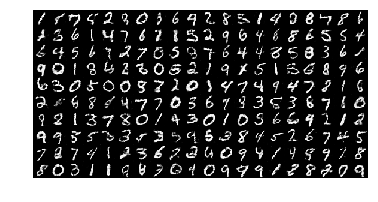

Epoch: [20] time: 2564.76s, d_loss: 1.2135, g_loss: 0.8113
Epoch: [21] time: 2685.68s, d_loss: 1.2486, g_loss: 0.8127
Epoch: [22] time: 2807.05s, d_loss: 1.2180, g_loss: 0.8350
Epoch: [23] time: 2928.53s, d_loss: 1.1950, g_loss: 0.8181
Epoch: [24] time: 3049.96s, d_loss: 1.2384, g_loss: 0.8123
Epoch: [25] time: 3171.14s, d_loss: 1.2027, g_loss: 0.8181
Epoch: [26] time: 3292.55s, d_loss: 1.2679, g_loss: 0.8300
Epoch: [27] time: 3413.91s, d_loss: 1.2157, g_loss: 0.7977
Epoch: [28] time: 3535.84s, d_loss: 1.1989, g_loss: 0.8319
Epoch: [29] time: 3657.38s, d_loss: 1.2358, g_loss: 0.8573


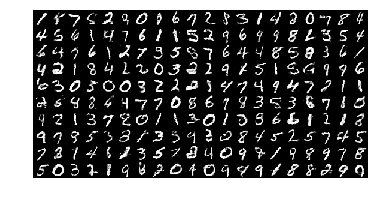

Epoch: [30] time: 3781.42s, d_loss: 1.2085, g_loss: 0.8093
Epoch: [31] time: 3902.34s, d_loss: 1.2528, g_loss: 0.8121
Epoch: [32] time: 4024.11s, d_loss: 1.2044, g_loss: 0.8227
Epoch: [33] time: 4145.37s, d_loss: 1.2081, g_loss: 0.8348
Epoch: [34] time: 4267.00s, d_loss: 1.2029, g_loss: 0.8173
Epoch: [35] time: 4388.16s, d_loss: 1.1964, g_loss: 0.8522
Epoch: [36] time: 4509.99s, d_loss: 1.2342, g_loss: 0.8121
Epoch: [37] time: 4630.84s, d_loss: 1.1982, g_loss: 0.8388
Epoch: [38] time: 4752.34s, d_loss: 1.2025, g_loss: 0.8477
Epoch: [39] time: 4873.61s, d_loss: 1.2059, g_loss: 0.8430


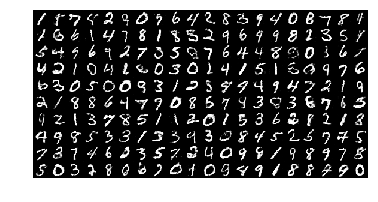

Epoch: [40] time: 4997.62s, d_loss: 1.2547, g_loss: 0.8395
Epoch: [41] time: 5119.42s, d_loss: 1.2661, g_loss: 0.8205
Epoch: [42] time: 5240.90s, d_loss: 1.1978, g_loss: 0.8742
Epoch: [43] time: 5362.51s, d_loss: 1.1933, g_loss: 0.8198
Epoch: [44] time: 5483.52s, d_loss: 1.1869, g_loss: 0.8287
Epoch: [45] time: 5605.07s, d_loss: 1.2004, g_loss: 0.8156
Epoch: [46] time: 5726.22s, d_loss: 1.2667, g_loss: 0.8201
Epoch: [47] time: 5848.02s, d_loss: 1.1814, g_loss: 0.8552
Epoch: [48] time: 5969.34s, d_loss: 1.1816, g_loss: 0.8308
Epoch: [49] time: 6090.94s, d_loss: 1.1958, g_loss: 0.8238


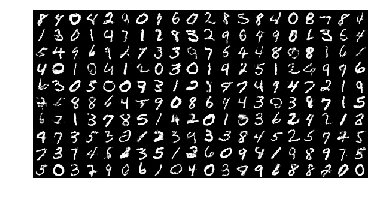

Epoch: [50] time: 6214.99s, d_loss: 1.2455, g_loss: 0.8667
Epoch: [51] time: 6336.17s, d_loss: 1.1860, g_loss: 0.8417
Epoch: [52] time: 6458.15s, d_loss: 1.2134, g_loss: 0.8936
Epoch: [53] time: 6579.57s, d_loss: 1.2069, g_loss: 0.8509
Epoch: [54] time: 6701.17s, d_loss: 1.1768, g_loss: 0.8416
Epoch: [55] time: 6822.86s, d_loss: 1.1354, g_loss: 0.8765
Epoch: [56] time: 6944.41s, d_loss: 1.1670, g_loss: 0.9097
Epoch: [57] time: 7065.97s, d_loss: 1.1806, g_loss: 0.8649
Epoch: [58] time: 7187.65s, d_loss: 1.1914, g_loss: 0.8641
Epoch: [59] time: 7309.01s, d_loss: 1.2051, g_loss: 0.9037


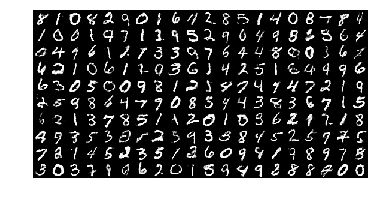

Epoch: [60] time: 7432.81s, d_loss: 1.1429, g_loss: 0.8868
Epoch: [61] time: 7554.61s, d_loss: 1.1996, g_loss: 0.8905
Epoch: [62] time: 7676.48s, d_loss: 1.1604, g_loss: 0.9036
Epoch: [63] time: 7798.18s, d_loss: 1.1506, g_loss: 0.8615
Epoch: [64] time: 7919.91s, d_loss: 1.1419, g_loss: 0.8826
Epoch: [65] time: 8041.51s, d_loss: 1.1477, g_loss: 0.8729
Epoch: [66] time: 8163.10s, d_loss: 1.1634, g_loss: 0.8309
Epoch: [67] time: 8284.53s, d_loss: 1.1797, g_loss: 0.8660
Epoch: [68] time: 8405.54s, d_loss: 1.1139, g_loss: 0.9287
Epoch: [69] time: 8527.41s, d_loss: 1.1263, g_loss: 0.8876


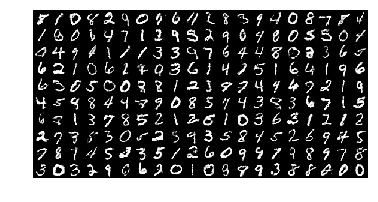

Epoch: [70] time: 8651.18s, d_loss: 1.1099, g_loss: 0.9152
Epoch: [71] time: 8772.59s, d_loss: 1.1062, g_loss: 0.8991
Epoch: [72] time: 8894.03s, d_loss: 1.1674, g_loss: 0.8661
Epoch: [73] time: 9015.81s, d_loss: 1.1713, g_loss: 0.8595
Epoch: [74] time: 9137.18s, d_loss: 1.1022, g_loss: 0.9313
Epoch: [75] time: 9259.11s, d_loss: 1.1209, g_loss: 0.9190
Epoch: [76] time: 9380.17s, d_loss: 1.1099, g_loss: 0.9027
Epoch: [77] time: 9502.30s, d_loss: 1.1221, g_loss: 0.9395
Epoch: [78] time: 9623.66s, d_loss: 1.1499, g_loss: 0.9392
Epoch: [79] time: 9745.00s, d_loss: 1.1096, g_loss: 0.8866


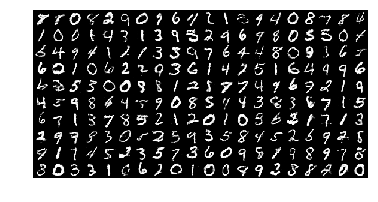

Epoch: [80] time: 9868.99s, d_loss: 1.1504, g_loss: 0.9320
Epoch: [81] time: 9990.56s, d_loss: 1.0973, g_loss: 0.9002
Epoch: [82] time: 10112.21s, d_loss: 1.1945, g_loss: 0.9534
Epoch: [83] time: 10233.75s, d_loss: 1.1179, g_loss: 0.9006
Epoch: [84] time: 10355.32s, d_loss: 1.0882, g_loss: 0.9334
Epoch: [85] time: 10476.84s, d_loss: 1.1276, g_loss: 0.9554
Epoch: [86] time: 10598.74s, d_loss: 1.0867, g_loss: 0.9580
Epoch: [87] time: 10720.23s, d_loss: 1.1241, g_loss: 0.9123
Epoch: [88] time: 10842.37s, d_loss: 1.0832, g_loss: 0.9727
Epoch: [89] time: 10963.88s, d_loss: 1.0758, g_loss: 0.9550


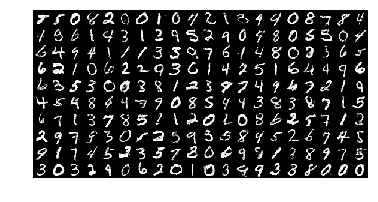

Epoch: [90] time: 11087.51s, d_loss: 1.3159, g_loss: 1.0306
Epoch: [91] time: 11208.97s, d_loss: 1.0395, g_loss: 1.0138
Epoch: [92] time: 11330.33s, d_loss: 1.0736, g_loss: 0.9444
Epoch: [93] time: 11451.04s, d_loss: 1.0442, g_loss: 0.9641
Epoch: [94] time: 11571.03s, d_loss: 1.1127, g_loss: 0.9477
Epoch: [95] time: 11692.29s, d_loss: 1.1852, g_loss: 0.9600
Epoch: [96] time: 11813.47s, d_loss: 1.1346, g_loss: 0.9030
Epoch: [97] time: 11934.96s, d_loss: 1.0762, g_loss: 0.9965
Epoch: [98] time: 12056.40s, d_loss: 1.0998, g_loss: 0.9308
Epoch: [99] time: 12178.16s, d_loss: 1.0637, g_loss: 0.9946


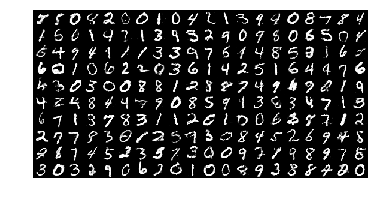

In [15]:
dcgan.train()

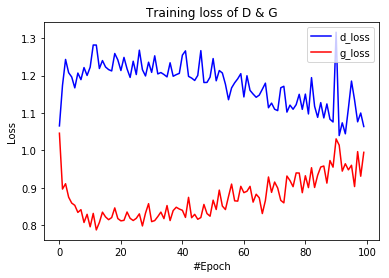

In [16]:


d_loss = dcgan.log['d_loss']
g_loss = dcgan.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()



In [21]:
imgs = np.array(dcgan.log['gen_samples'])
make_gif(imgs * 255., 'GAN/dcgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/dcgan.gif')


[MoviePy] Building file GAN/dcgan.gif with imageio


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:01<00:00, 63.99it/s]


In [20]:
# import imageio
# imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.win32.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.win32.exe (27.4 MB)
Downloading: 8192/28781056 bytes (0.073728/28781056 bytes (0.3%229376/28781056 bytes (0.8442368/28781056 bytes (1.5655360/28781056 bytes (2.3868352/28781056 bytes (3.01081344/28781056 bytes (3.8%1294336/28781056 bytes (4.5%1507328/28781056 bytes (5.2%1720320/28781056 bytes (6.0%1933312/28781056 bytes (6.7%2113536/28781056 bytes (7.3%2293760/28781056 bytes (8.0%2473984/28781056 bytes (8.6%2867200/28781056 bytes (10.03080192/28781056 bytes (10.73293184/28781056 bytes (11.43506176/28781056 bytes (12.23719168/28781056 bytes (12.93932160/28781056 bytes (13.74145152/28781056 bytes (14.44358144/28781056 bytes (15.14489216/28781056 bytes (15.64849664/28781056 bytes (16.95062656/28781056 bytes (17.65242880/28781056 bytes (18.25390336/28781056 bytes (18.75570560/28781056 bytes (19.45783552/28781056 bytes (20.

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint\mnist_128\DCGAN.model-43001
 [*] Success to read DCGAN.model-43001


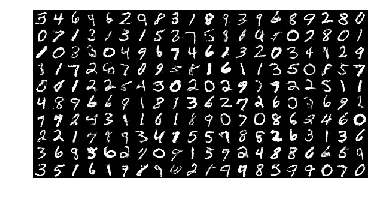

In [22]:
tf.reset_default_graph()
sess.close()

sess = tf.Session()
dcgan = DCGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,)

if not dcgan.load(checkpoint_dir)[0]:
  raise Exception("[!] Train a model first, then run test mode")

sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = dcgan.G.eval(session=dcgan.sess, feed_dict={dcgan.z: sample_z})
# samples = dcgan.trX[:20]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [23]:
tf.reset_default_graph()
sess.close()

In [7]:
#Inherit from DCGAN class
class WGAN(DCGAN):

  def build_model(self):

    # Training critic 5 iterations per generator iteration
    self.n_critic = 5

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    self.saver = tf.train.Saver()

  def train(self):
    g_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.g_loss, var_list=self.g_vars)
    d_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.d_loss, var_list=self.d_vars)

    #get the weight clipping ops
    clip_ops = []
    for var in self.d_vars:
      clip_bounds = [-.01, .01]
      clip_ops.append(
          tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
    clip_disc_weights = tf.group(*clip_ops)

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        print(batch_z.shape,batch_images.shape)
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
          #Apply weight clipping to D network
          self.sess.run(clip_disc_weights)
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


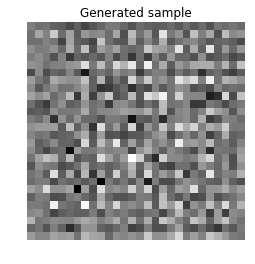

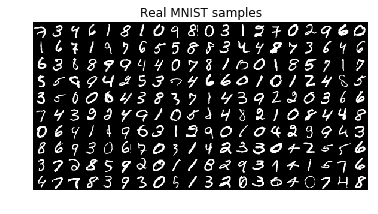

(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28,

(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)
(128, 100) (128, 28, 28, 1)


KeyboardInterrupt: 

In [8]:
# Specifiy model checkpoint directory & samples directory
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

sess = tf.Session()
model = WGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)

# show_all_variables()
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

model.train()

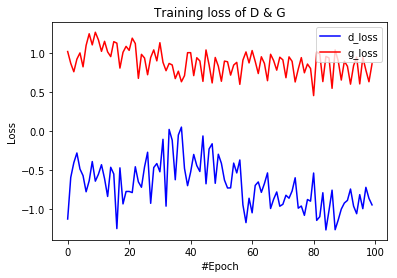

In [26]:
d_loss = model.log['d_loss']
g_loss = model.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [27]:
imgs = np.array(model.log['gen_samples'])
make_gif(imgs * 255., 'GAN/wgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/wgan.gif')


[MoviePy] Building file GAN/wgan.gif with imageio


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:02<00:00, 49.10it/s]


In [28]:
tf.reset_default_graph()
sess.close()

In [29]:
from IPython.display import Image
Image(url='GAN/iwgan.gif')